In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline


In [2]:
from transformers import (
    GPT2Config,
    GPT2Tokenizer,
    GPT2LMHeadModel,
)

/home/cgagne/cvar_generation/conda_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
modelname = '../models/pretrained/gpt2-large/'
config = GPT2Config.from_pretrained(modelname)
tokenizer = GPT2Tokenizer.from_pretrained(modelname)

In [4]:
import sys
sys.path.append('../')
from rl_learner import TD_Learner
import torch
import pickle
device = 'cpu'
import sys
sys.path.append('../')

from cvar_helpers import calc_cvar_from_samples
from train_rl_batch_sentence_chains import average_states_by_period

### Loading Training Data 

In [5]:
file = '../data/results/sentence_chains_I_3/generations.txt'
f = open(file, "r")
sentences = f.readlines()
sentences = [s.replace('\n','') for s in sentences]
sentences = [s.split('r_all=')[0] for s in sentences]
state_rewards =  [np.array(s.split('r=')[-1].split(',')).astype('float') for s in sentences]

In [6]:
# removing some bad examples #
state_rewards2 = []
sentences2 = []
for r,s in zip(state_rewards, sentences):
    if len(r)!=3:
        pass
    else:
        state_rewards2.append(r)
        sentences2.append(s)
sentences = sentences2
state_rewards = np.array(state_rewards2)

# choose rewards 
summed_rewards = state_rewards.sum(axis=1)
final_rewards = state_rewards[:,-1]

assert len(sentences) == len(final_rewards)

In [7]:
#np.array(state_rewards)

In [8]:
len(sentences)
len(final_rewards)

1000

In [9]:
print(sentences[0:5])
print(final_rewards[0:5])
print(state_rewards[0:5])

["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to keep the house up and running. I need to make sure that there is a water supply in the family's backyard. I need to show up, because I have a house to show for tonight. p=0.114,0.105,0.126 r=0.071,0.082,0.254 ", 'Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to have work done. I need to take care of that child that needs to be fed. I need to take care of that little girl who is hungry all the time. p=0.198,0.117,0.091 r=-0.144,-0.173,-0.472 ', "Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to get ready. Think about what you need to do tomorrow. So I'll be back on Friday. p=0.109,0.153,0.1 r=-0.041,-0.008,0.259 ", "Let me think ab

Text(0.5, 1.0, 'final reward')

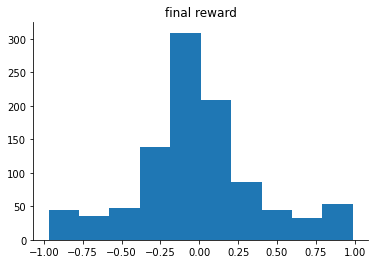

In [10]:
plt.hist(final_rewards)
sns.despine()
plt.title('final reward')

Text(0.5, 1.0, 'summed reward')

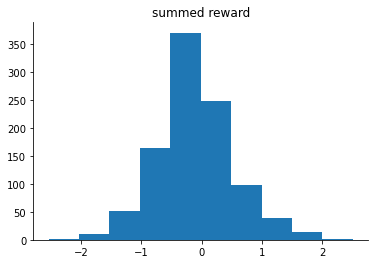

In [11]:
plt.hist(summed_rewards)
sns.despine()
plt.title('summed reward')

### Print some Negative Examples

In [12]:
sort_idx = np.argsort(final_rewards)
for s in np.array(sentences)[sort_idx][0:20]:
    print(s)
    print()

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to dress her, mow the lawn, and clean up the house. She is pretty, isn't she? … God. I'm in such a sour mood today. p=0.086,0.099,0.092 r=-0.015,0.939,-0.97 

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to read the paper. But there's no real temptation to eat. I don't like to eat. p=0.083,0.078,0.117 r=-0.055,-0.154,-0.954 

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to make dinner. Then I need to go to the community center. I don't want to see people standing on each other's lawns and arguing. p=0.083,0.096,0.086 r=0.068,0.045,-0.954 

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get th

In [14]:
sort_idx = np.argsort(summed_rewards)
for s in np.array(sentences)[sort_idx][0:20]:
    print(s)
    print()

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. The tension in the house is spreading. I need to get out of this house. I need to get myself out of here. p=0.085,0.097,0.149 r=-0.867,-0.911,-0.761 

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to throw the trash out, he said. He is old enough to start the trash can. My dog will be a burden. p=0.088,0.1,0.158 r=-0.634,-0.667,-0.896 

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to get ready for work. It could be worse, I could end up there because we have no one to take the kids. It could also be worse, I could end up at the nursing home that only takes the elderly. p=0.083,0.093,0.099 r=-0.149,-0.929,-0.946 

Let me think about what I n


### Print some Positive Examples

In [13]:
sort_idx = np.argsort(final_rewards)
for s in np.array(sentences)[sort_idx][-20:]:
    print(s)
    print()

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. The whole team needs to get ready and get ready for the next game. That's another step. If I'm doing one thing right right now, that's good. p=0.138,0.091,0.091 r=0.18,0.361,0.946 

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to do all these things. And, I want them to have fun. I want to keep them happy and with a smile on their face. p=0.111,0.11,0.089 r=0.203,0.851,0.946 

Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to wash my hands, and make sure I have the right tools. There's a lot of things I need to do. I've got some great friends there. p=0.089,0.105,0.227 r=-0.022,-0.115,0.947 

Let me think about what I need to do tomorrow, be

### Load the Quantile Learner

In [33]:
epoch=80
hidden_dim =100
n_quantiles = 10
prompt_enc = ''
filename='../data/results/sentence_chains_I_3/'
filename+=f'quantile_learner_{hidden_dim}_0.1{prompt_enc}/log_quantile_learner_epoch{epoch}.pkl'

Z_network = TD_Learner(config.n_embd, n_quantiles, hidden_dim=hidden_dim)
Z_network.load_state_dict(torch.load(filename.replace('log_',''),map_location=torch.device('cpu')))

log = pickle.load(open(filename,'rb'))
loss = np.array(log['loss'])
epoch = np.array(log['epoch'])

### Training Loss

Text(0.5, 0, 'epochs')

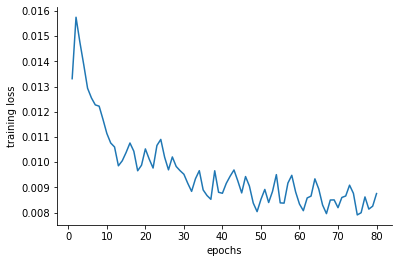

In [34]:
plt.plot(epoch, loss)
sns.despine()
plt.ylabel('training loss')
plt.xlabel('epochs')

### Stored Examples 

- for 100, I was not storing the examples correctly

In [35]:
examples = ['I puked all over my living room floor and waited.',
                        "You're dirty.",
                        'I took the stupid potty training class and passed out on the mat.',
                        'My knuckles are tired.',
                        'I got on a park bench and happily listened to Mozart and Praxis performed.',
                        'I was, of course, all six packer eyes.',
                        "That was his New Year's Resolution: health.",
                        "It was very nice.",
                        "The benefits of moving early always seem pretty obvious to me.",
                        "The sun was shining and I'd made it to campus on time."]

In [36]:
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
taus

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

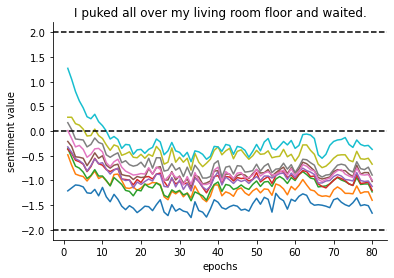

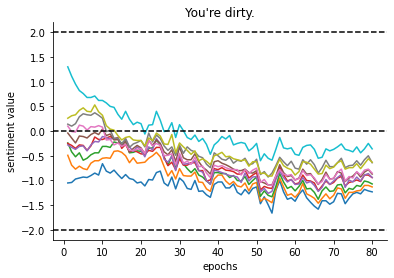

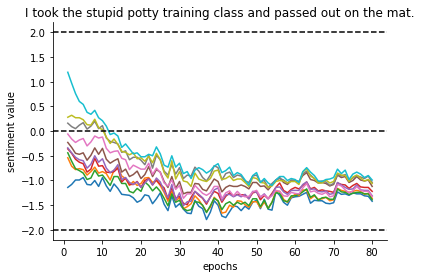

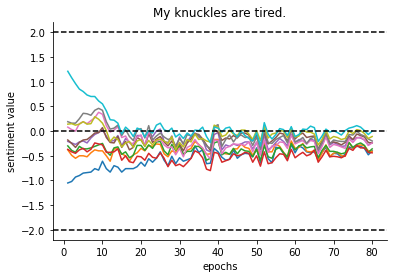

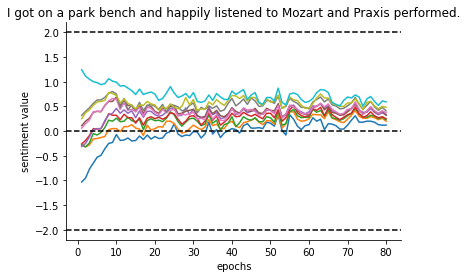

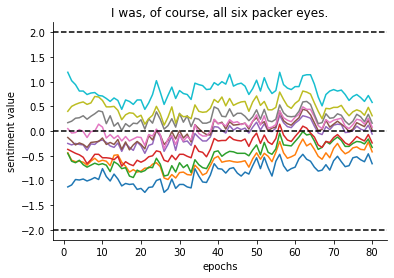

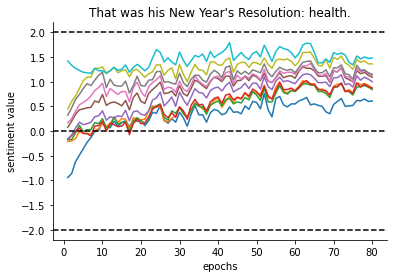

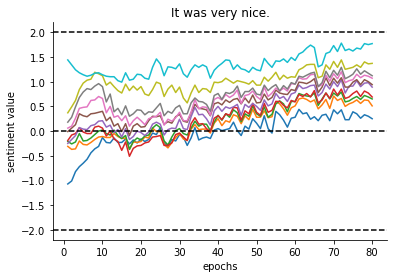

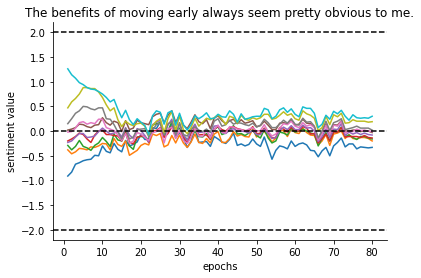

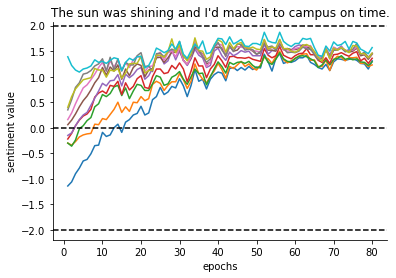

In [37]:
for example in examples:
    
    if example in log.keys():
        plt.figure()
        plt.plot(epoch, np.array(log[example]))
        sns.despine()
        plt.axhline(y=-2, color='k', linestyle='--')
        plt.axhline(y=0, color='k', linestyle='--')
        plt.axhline(y=2, color='k', linestyle='--')
        plt.ylabel('sentiment value')
        plt.xlabel('epochs')
        plt.title(example)

        sel = np.array([example in s for s in sentences]).astype('bool')
        if np.sum(sel)>0:
            thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus]
            print(thetas)
            for theta in thetas:
                    plt.axhline(y=theta, linestyle='--', color='k', linewidth=0.5)

### Examples from training set

In [38]:
model = GPT2LMHeadModel.from_pretrained(modelname)
device='cpu'

In [63]:
examples = ['I puked all over my living room floor and waited.',
                        "You're dirty.",
                        'I took the stupid potty training class and passed out on the mat.',
                        'My knuckles are tired.',
                        'I got on a park bench and happily listened to Mozart and Praxis performed.',
                        'I was, of course, all six packer eyes.',
                        "That was his New Year's Resolution: health.",
                        "It was very nice.",
                        "The benefits of moving early always seem pretty obvious to me.",
                        "The sun was shining and I'd made it to campus on time.",
           'I got dressed.',
           'I took my shower.',
           'I went to the bathroom.',
           "Let me think about what I need to do tomorrow, because it will be a busy day.",
           'Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog.',
           "Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to move the furniture to another room. I can't help being distracted by the whole mommy and baby thing. I talk to Erica, and I can tell she's upset." 
           ]






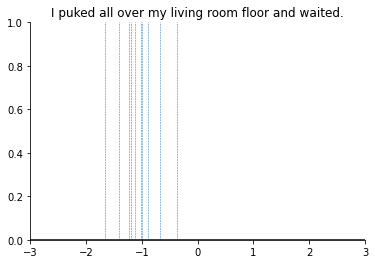

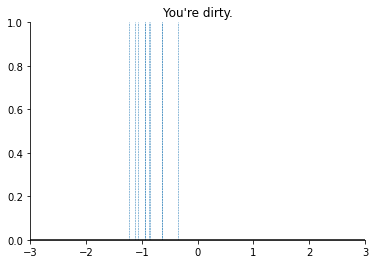

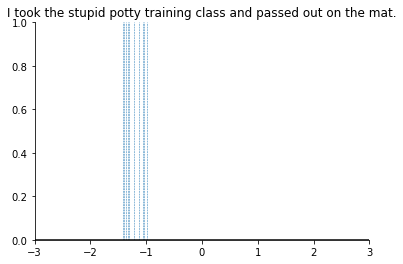

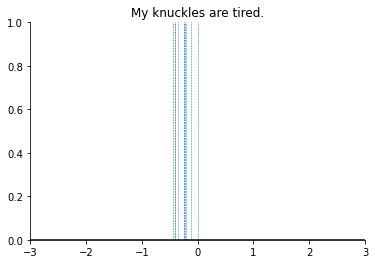

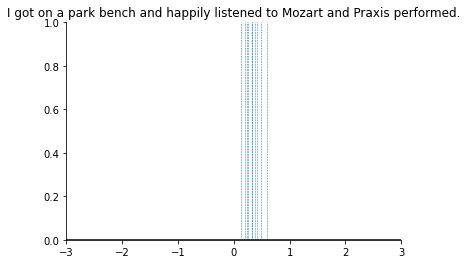

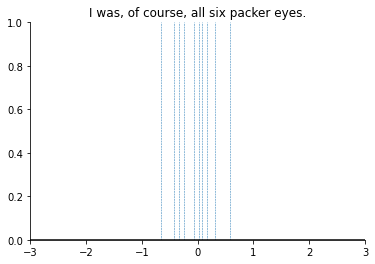

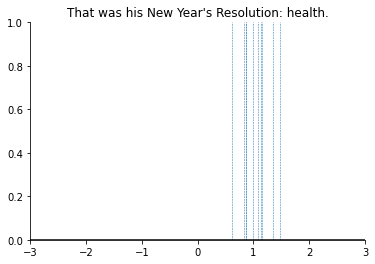

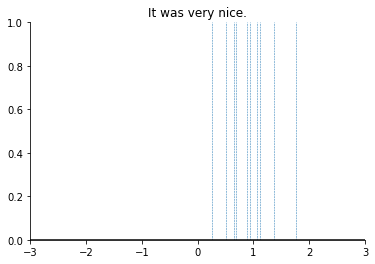

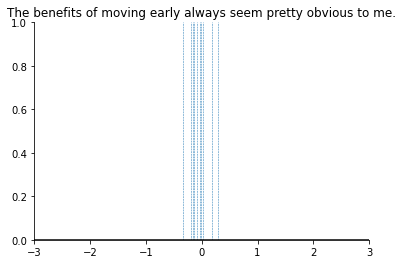

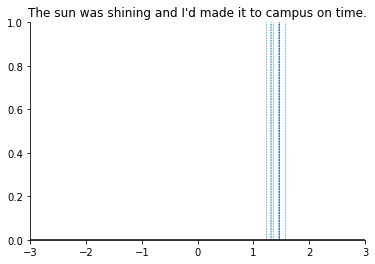

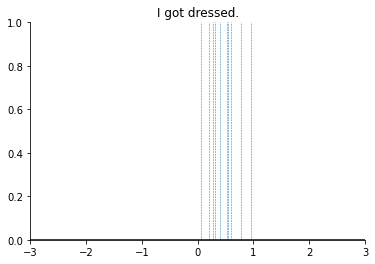

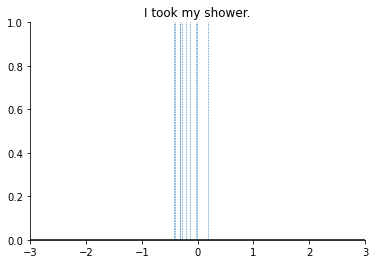

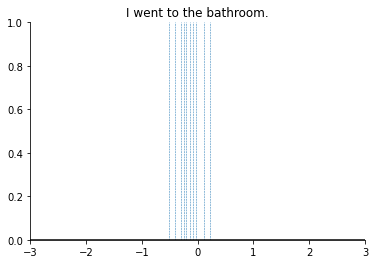

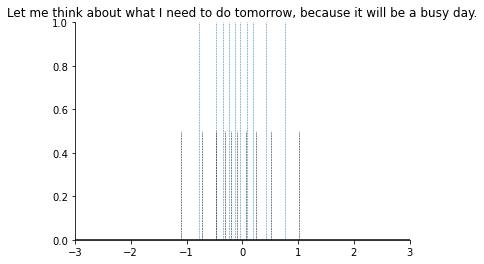

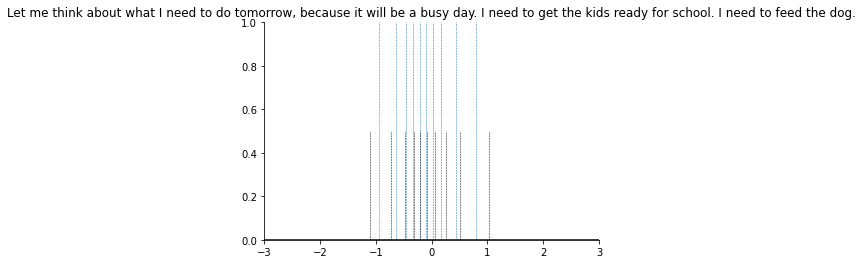

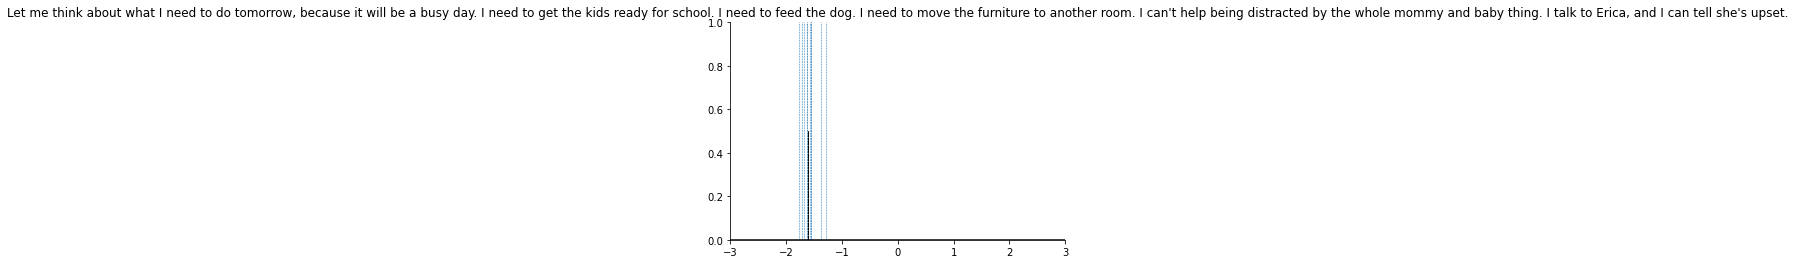

In [66]:
for example in examples:
    
    inputs = tokenizer(example, return_tensors='pt').to(device)
    with torch.no_grad():
        input_ids = inputs['input_ids']
        mask = inputs['attention_mask']
        output = model(input_ids=input_ids,
                       attention_mask=mask,
                       output_hidden_states=True)
        states = output['hidden_states'][-1]
        states, _ = average_states_by_period(states, mask.unsqueeze(-1), input_ids, device,
                                            n_periods=example.count('.'), period_tok_id=13, pad_tok_id=50256)
        
        theta_hats = Z_network(states).detach().cpu().numpy().round(2)
        theta_hats_last = theta_hats[:,-1,:].squeeze()
    #print(theta_hats_last)

    plt.figure()
    
    for theta in theta_hats_last:
        plt.axvline(x=theta, linestyle='--', linewidth=0.5)

    sel = np.array([example in s for s in sentences]).astype('bool')
    if np.sum(sel)>0:
        thetas = [np.quantile(summed_rewards[sel].squeeze(), q) for q in taus]
        for theta in thetas:
            plt.axvline(x=theta, ymax=0.5, linestyle='--', linewidth=0.5, color='k')

    plt.xlim([-3,3])
    plt.axhline(y=0., color='k')
    sns.despine()
    plt.title(example)

### Plotting Distributions

In [86]:
sentences_cvar = {}
rewards_cvar = {}
alphas = [0.05, 0.1]
#alphas = [0.08]
top_k =10
prompt_enc = ''
for alpha in alphas:

    file = f'../data/results/sentence_chains_I_3/generations_{alpha}.txt'
    f = open(file, "r")
    sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])
    rewards_cvar[alpha] =  []
    for s in sentences_cvar[alpha]:
        r = np.sum(np.array(s.split('r=')[-1].split(',')).astype('float'))
        rewards_cvar[alpha].append(r)

    rewards_cvar[alpha]=np.array(rewards_cvar[alpha])

In [87]:
#np.array(s.split('r=')[-1].split(',')).astype('float')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


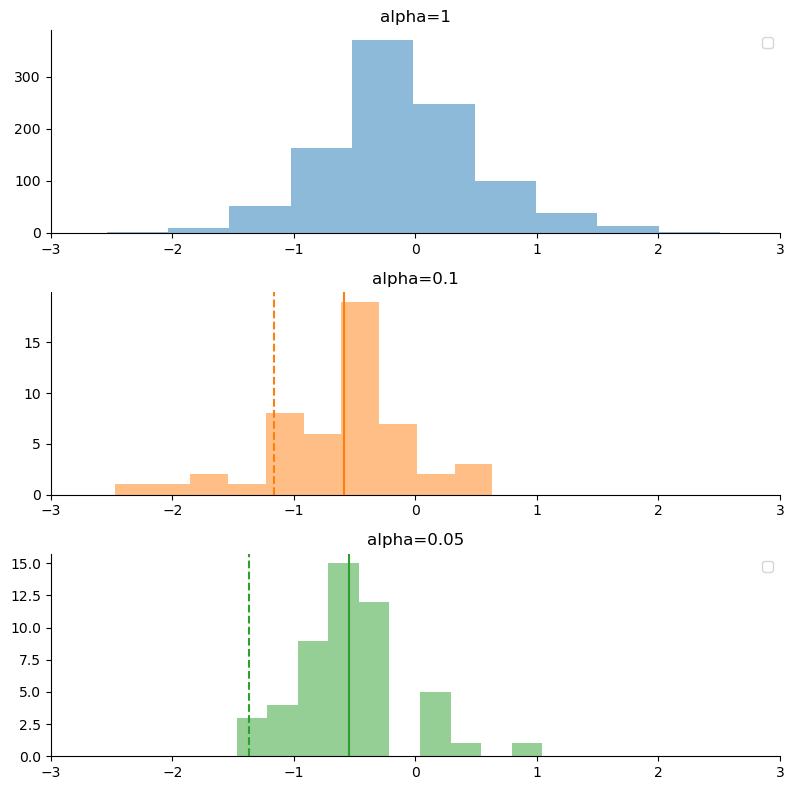

In [88]:

# full distribution
stem = ""
sel = np.array([s.startswith(stem) for s in sentences]).astype('bool')
fig,axes = plt.subplots(len(alphas)+1, 1, figsize=(8,4*len(alphas)), dpi=100)

plt.sca(axes[0])
plt.hist(summed_rewards[sel], alpha=0.5, label=f'{stem}', density=False)

plt.legend()
sns.despine()
plt.xlim([-3,3])
plt.title(f'alpha=1')

# alphas 
for a, alpha in enumerate(alphas[::-1]):
    
    plt.sca(axes[a+1]) 
    sel_cvar = np.array([s.startswith(stem) for s in sentences_cvar[alpha]]).astype('bool')
    plt.hist(rewards_cvar[alpha][sel_cvar], alpha=0.5, color=sns.color_palette()[a+1],
             label=f'{stem}',density=False)
    
    _, cvar = calc_cvar_from_samples(summed_rewards[sel], alpha)
    mean = np.nanmean(rewards_cvar[alpha][sel_cvar])
    plt.axvline(x=cvar, color=sns.color_palette()[a+1], linestyle='--')
    plt.axvline(x=mean, color=sns.color_palette()[a+1])
    plt.xlim([-3,3])
    plt.title(f'alpha={alpha}')
    
plt.legend()
plt.tight_layout()

### Printing Examples

In [82]:
n_quantiles = 10
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
alpha_set = list(np.append(np.insert(taus, 0, 0), 1)) # add zero, one
taus_set = list(taus)
taus_set

[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [89]:
alpha_storage = {}
p_storage = {}
pd_storage = {}
sentences_storage = {}
rewards_storage = {}
cvar_storage = {}
quantile_storage = {}
top_k=10

for alpha in [0.05, 0.08, 0.1]:

    file = f'../data/results/sentence_chains_I_3/cvar_output_{alpha}.pkl'
    
    loaded = pickle.load(open(file,'rb'))
    alpha_storage[alpha] = loaded['alpha_storage']
    p_storage[alpha] = loaded['p_storage']
    pd_storage[alpha] = loaded['pd_storage']
    sentences_storage[alpha] = loaded['sentences_storage']
    rewards_storage[alpha] = loaded['rewards_storage']
    cvar_storage[alpha] = loaded['cvar_storage']
    quantile_storage[alpha] = loaded['quantile_storage']

In [92]:
alpha =0.1
#alpha =0.05
for s, (sentence,r) in enumerate(zip(sentences_storage[alpha], rewards_storage[alpha])):
    if sentence not in sentences:
        print(s, sentence, np.round(r,2), np.round(np.sum(r),2))
        print()

0 ['Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to get the kids at school, but not leave to go to the movies. (p. p=0.188,0.301 r=-0.232,-0.067\n'] [-0.23 -0.07] -0.3

1 ['Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to have work done. I need to take care of that child that needs to be fed. I need to leave that one down there, the dog that needs to be fed. p=0.626,0.359,0.071 r=-0.144,-0.173,-0.276\n'] [-0.14 -0.17 -0.28] -0.59

2 ["Let me think about what I need to do tomorrow, because it will be a busy day. I need to get the kids ready for school. I need to feed the dog. I need to get ready. And I need to wait until tomorrow. And my dog's ready. p=0.371,0.207,0.16 r=-0.041,-0.542,0.499\n"] [-0.04 -0.54  0.5 ] -0.08

3 ['Let me think about what I need to do tomorrow, because it

In [91]:
np.array(rewards_storage[0.05][1::]).mean(axis=0)

array([-0.17748865, -0.21330485, -0.16157498])